In [1]:
##############################################################
# Libraries

import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

import os
from datetime import datetime, timedelta
import gc
from tqdm import tqdm
tqdm.pandas()
import time

import tensorflow as tf
from tensorflow.keras import layers, losses, models, metrics, optimizers, constraints
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence
from tensorflow_addons.optimizers import AdamW

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

##############################################################

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
##############################################################
# tfrecords for kaggle

# name_dataset = 'tfrecords_v0.3_kaggle'
# path_out = f'../tfrecords/{name_dataset}/'

# if not os.path.exists(path_out):
#     os.mkdir(path_out)

# for file in os.listdir(path_out + 'na_split_train'):
#     os.rename(path_out + 'na_split_train/' + file, 
#               path_out + 'na_split_train/' + file.replace('-', '_').replace('gz', 'tfrec'))

# for file in os.listdir(path_out + 'na_split_val'):
#     os.rename(path_out + 'na_split_val/' + file, 
#               path_out + 'na_split_val/' + file.replace('-', '_').replace('gz', 'tfrec'))

# for file in os.listdir(path_out + 'na_split_test'):
#     os.rename(path_out + 'na_split_test/' + file, 
#               path_out + 'na_split_test/' + file.replace('-', '_').replace('gz', 'tfrec'))


##############################################################

In [3]:
##############################################################
# Paths & Global Variables

# Train: (datetime.datetime(2022, 7, 31, 22, 0, 0, 25000), datetime.datetime(2022, 8, 28, 21, 59, 59, 984000))
# Test: (datetime.datetime(2022, 8, 28, 22, 0, 0, 278000), datetime.datetime(2022, 9, 4, 21, 59, 51, 563000))

path_data_raw = '../0_Data/'

SEED = 12
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
AUTO = tf.data.AUTOTUNE

df_mapping = pd.read_csv('../tfrecords/tfrecords_v0.3/df_mapping.csv')
NUM_ITEMS = len(df_mapping['aid_map'].unique())
print(NUM_ITEMS)

dict_map = {}
for x in tqdm(df_mapping.to_dict('records')):
    dict_map[x['aid_map']] = x['aid']

dict_map_type = {
    'clicks' : 1,
    'carts' : 2,
    'orders' : 3
  }

##############################################################

In [ ]:
class Bert4RecDataLoader:
    """
    Class that iterates over tfrecords in order to get the sequences.
    """
    def __init__(self, list_paths, num_items, seq_len, batch_size, num_targets=-1, mask_prob=0.4, 
                 reverse_prob=0.2, get_session=False, get_only_first_on_val=False, seq_len_target=None,
                 min_size_seq_to_mask=2, is_val=False, is_test=False, avoid_repeats=False, shuffle=False, drop_remainder=False):
        self.list_paths = list_paths
        self.num_items = num_items
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_targets = num_targets
        self.mask_prob = mask_prob
        self.reverse_prob = tf.constant(reverse_prob)
        self.shuffle = shuffle
        self.min_size_seq_to_mask = min_size_seq_to_mask
        self.avoid_repeats = avoid_repeats
        self.get_session = get_session
        self.seq_len_target = seq_len if not seq_len_target else seq_len_target
        self.get_only_first_on_val = get_only_first_on_val
        self.is_val = is_val
        self.is_test = is_test
        self.drop_remainder = drop_remainder

    def get_generator(self):
        dataset = tf.data.TFRecordDataset(self.list_paths, num_parallel_reads=AUTO, compression_type='GZIP')
        dataset = dataset.map(self.parse_tf_record, num_parallel_calls=AUTO)
        if self.is_val:
            dataset = dataset.map(self.make_transforms_val, num_parallel_calls=AUTO)
        elif self.is_test:
            dataset = dataset.map(self.make_transforms_test, num_parallel_calls=AUTO)
        else:
            dataset = dataset.map(self.make_transforms_train, num_parallel_calls=AUTO)
        dataset = dataset.map(self.set_shapes, num_parallel_calls=AUTO)
        if self.shuffle:
            dataset = dataset.shuffle(self.batch_size*50, reshuffle_each_iteration=True)

        dataset = dataset.batch(self.batch_size, num_parallel_calls=AUTO, drop_remainder=self.drop_remainder).prefetch(AUTO)
        return dataset

    def parse_tf_record(self, data):
        features_context = {
             "session": tf.io.FixedLenFeature([], tf.int64),
             "size_session": tf.io.FixedLenFeature([], tf.int64),
        }
        if not self.is_val:
            features_seq = {
                "seq_aid" : tf.io.FixedLenSequenceFeature(shape=[1], dtype=tf.int64, allow_missing=False),
                "seq_type": tf.io.FixedLenSequenceFeature(shape=[1], dtype=tf.int64, allow_missing=False),
                "seq_time_encoding": tf.io.FixedLenSequenceFeature(shape=[8], dtype=tf.float32, allow_missing=False)
            }
        else:
            features_seq = {
                "seq_aid" : tf.io.FixedLenSequenceFeature(shape=[1], dtype=tf.int64, allow_missing=False),
                "seq_type": tf.io.FixedLenSequenceFeature(shape=[1], dtype=tf.int64, allow_missing=False),
                "seq_aid_target" : tf.io.FixedLenSequenceFeature(shape=[1], dtype=tf.int64, allow_missing=False),
                "seq_type_target": tf.io.FixedLenSequenceFeature(shape=[1], dtype=tf.int64, allow_missing=False),
                "seq_time_encoding": tf.io.FixedLenSequenceFeature(shape=[8], dtype=tf.float32, allow_missing=False)
            }
        data_context, data_sequence = tf.io.parse_single_sequence_example(data, context_features=features_context, sequence_features=features_seq)
        return data_context, data_sequence

    def pad_sequence(self, seq_to_pad, maxlen, return_pad_mask=False, dtype=tf.float32):
        length, num_feats = tf.shape(seq_to_pad)[0], tf.shape(seq_to_pad)[-1]
        ###
        if length < maxlen:
            pad = tf.zeros((maxlen - length, num_feats), dtype)
            seq = tf.concat([seq_to_pad, pad], axis=0)
            pad_mask = tf.concat([tf.ones(tf.shape(seq_to_pad), dtype=seq_to_pad.dtype), 
                                 pad], axis=0)
        else:
            seq = seq_to_pad[-maxlen:, :]
            pad_mask = tf.ones((maxlen, tf.shape(seq_to_pad)[-1]), dtype=seq_to_pad.dtype)
        if return_pad_mask:
            return seq, pad_mask
        return seq 

    def make_transforms_val(self, dict_context, dict_sequences):
        seq_items, seq_type, seq_time_encoding =  dict_sequences['seq_aid'], dict_sequences['seq_type'], dict_sequences['seq_time_encoding']
        seq_items_target_raw, seq_type_target_raw =  dict_sequences['seq_aid_target'], dict_sequences['seq_type_target']
        session, qt_size_seq = dict_context['session'], dict_context['size_session']
        ###
        # Build target
        seq_items, seq_target = seq_items, seq_items_target_raw[:1] if not self.get_session else seq_items_target_raw[:self.seq_len_target]
        seq_type, seq_type_target = seq_type, seq_type_target_raw[:1] if not self.get_session else seq_type_target_raw[:self.seq_len_target]
        seq_time_encoding, seq_time_encoding_target = seq_time_encoding, tf.zeros((1, tf.shape(seq_time_encoding)[1]), tf.float32)
        seq_items_target = tf.concat([seq_items, seq_target], axis=0)
        seq_type_target = tf.concat([seq_type, seq_type_target], axis=0)
        ###
        #Mask last position
        seq_items = tf.concat([seq_items, tf.zeros((1, tf.shape(seq_items)[1]), tf.int64)], axis=0)
        seq_type = tf.concat([seq_type, seq_type_target[:1]], axis=0)
        seq_time_encoding = tf.concat([seq_time_encoding, tf.zeros((1, tf.shape(seq_time_encoding)[1]), tf.float32)], axis=0)
        ###
        seq_items, pad_mask = self.pad_sequence(seq_items, maxlen=self.seq_len, return_pad_mask=True, dtype=tf.int64)
        seq_type = self.pad_sequence(seq_type, maxlen=self.seq_len, return_pad_mask=False, dtype=tf.int64)
        seq_time_encoding = self.pad_sequence(seq_time_encoding, maxlen=self.seq_len, return_pad_mask=False, dtype=tf.float32)  
        seq_items_target = self.pad_sequence(seq_items_target, maxlen=self.seq_len_target, return_pad_mask=False, dtype=tf.int64)  
        seq_type_target = self.pad_sequence(seq_type_target, maxlen=self.seq_len_target, return_pad_mask=False, dtype=tf.int64)
        
        if self.get_session:
            seq_items_target_all = self.pad_sequence(seq_items_target_raw[:self.seq_len_target], maxlen=self.seq_len_target, return_pad_mask=False, dtype=tf.int64)  
            seq_type_target_all = self.pad_sequence(seq_type_target_raw[:self.seq_len_target], maxlen=self.seq_len_target, return_pad_mask=False, dtype=tf.int64) 
            return (seq_items, seq_type, seq_time_encoding), (seq_items_target_all[:, 0], seq_type_target_all[:, 0]), session

        return (seq_items, seq_type, seq_time_encoding), seq_items_target[:, 0]

    def make_transforms_test(self, dict_context, dict_sequences):
        seq_items, seq_type, seq_time_encoding =  dict_sequences['seq_aid'], dict_sequences['seq_type'], dict_sequences['seq_time_encoding']
        session, qt_size_seq = dict_context['session'], dict_context['size_session']
        ###
        seq_items = seq_items[-self.seq_len:, :]
        seq_type = seq_type[-self.seq_len:, :]
        seq_time_encoding = seq_time_encoding[-self.seq_len:, :]
        #Mask last position
        seq_items = tf.concat([seq_items, tf.zeros((1, tf.shape(seq_items)[1]), tf.int64)], axis=0)
        seq_type = tf.concat([seq_type, tf.zeros((1, tf.shape(seq_type)[1]), tf.int64)], axis=0)
        seq_time_encoding = tf.concat([seq_time_encoding, tf.zeros((1, tf.shape(seq_time_encoding)[1]), tf.float32)], axis=0)
        ###
        seq_items, pad_mask = self.pad_sequence(seq_items, maxlen=self.seq_len, return_pad_mask=True, dtype=tf.int64)
        seq_type = self.pad_sequence(seq_type, maxlen=self.seq_len, return_pad_mask=False, dtype=tf.int64)
        seq_time_encoding = self.pad_sequence(seq_time_encoding, maxlen=self.seq_len, return_pad_mask=False, dtype=tf.float32)   

        if self.get_session:
            return (seq_items, seq_type, seq_time_encoding), tf.zeros(tf.shape(seq_items)), session

        return (seq_items, seq_type, seq_time_encoding), tf.zeros(tf.shape(seq_items))

  
    def make_transforms_train(self, dict_context, dict_sequences):
        seq_items, seq_type, seq_time_encoding =  dict_sequences['seq_aid'], dict_sequences['seq_type'], dict_sequences['seq_time_encoding']
        qt_size_seq = dict_context['size_session']
        ### 
        # With prob reverse
        if tf.random.uniform(shape=(1,1)) <= self.reverse_prob:
            seq_items = tf.reverse(seq_items, axis=[0])
            seq_type = tf.reverse(seq_type, axis=[0])
            seq_time_encoding = tf.reverse(seq_time_encoding, axis=[0])
            
        # If our seq is longer than seq_len we can use it for data augmentation purpose 
        # and select a random idx to begin with.
        if tf.shape(seq_items)[0] > self.seq_len:
            idx_list = tf.range(tf.shape(seq_items)[0]-self.seq_len) 
            rand_idx = tf.random.shuffle(idx_list)[0]
            seq_items = seq_items[rand_idx:(rand_idx+self.seq_len), :]
            seq_type = seq_type[rand_idx:(rand_idx+self.seq_len), :]
            seq_time_encoding = seq_time_encoding[rand_idx:(rand_idx+self.seq_len), :]
        
        qt_size_seq = tf.shape(seq_items)[0]

        ## Get idxs to mask for inputs and targets
        probs = tf.random.uniform(shape=(qt_size_seq,), minval=0, maxval=1)
        idxs_inputs = tf.cast(tf.where(probs >= (1-self.mask_prob)), tf.int64) # -> we mask to zero the inputs as we dont want to leak 
        idxs_target = tf.cast(tf.where(probs < (1-self.mask_prob)), tf.int64) # -> we mask to zero the targets as the loss will only be applied on non zero

        # If all items are masked we leave an item unmasked
        if tf.cast(tf.shape(idxs_inputs)[0], tf.int64) == tf.cast(qt_size_seq, tf.int64):
            idxs_target = idxs_inputs[-1:]
            idxs_inputs = idxs_inputs[:-1]
            
        # If no item has been masked we leave at least one item masked(be careful of size=1 seqs)
        if tf.cast(tf.shape(idxs_inputs)[0], tf.int64) == tf.constant(0, dtype=tf.int64):
            all_idxs = tf.cast(tf.random.shuffle(tf.range(0, qt_size_seq)), dtype=tf.int64)
            idxs_inputs = all_idxs[:1][:, tf.newaxis]
            idxs_target = all_idxs[1:][:, tf.newaxis]

        # Mask inputs and targets
        seq_items_raw = seq_items
        updates_items = tf.zeros((len(idxs_inputs), seq_items.shape[-1]), tf.int64)
        # updates_type = tf.zeros((len(idxs_inputs), seq_type.shape[-1]), tf.int64)
        updates_time_encoding = tf.zeros((len(idxs_inputs), seq_time_encoding.shape[-1]), tf.float32)
        updates_target = tf.zeros((len(idxs_target), seq_items_raw.shape[-1]), tf.int64)
        
        seq_items = tf.tensor_scatter_nd_update(seq_items, idxs_inputs, updates_items)
        # seq_type = tf.tensor_scatter_nd_update(seq_type, idxs_inputs, updates_type)
        seq_time_encoding = tf.tensor_scatter_nd_update(seq_time_encoding, idxs_inputs, updates_time_encoding)
        seq_target = tf.tensor_scatter_nd_update(seq_items_raw, idxs_target, updates_target)
        
        # Padding
        seq_items, pad_mask = self.pad_sequence(seq_items, maxlen=self.seq_len, return_pad_mask=True, dtype=tf.int64)
        seq_type = self.pad_sequence(seq_type, maxlen=self.seq_len, return_pad_mask=False, dtype=tf.int64)
        seq_time_encoding = self.pad_sequence(seq_time_encoding, maxlen=self.seq_len, return_pad_mask=False, dtype=tf.float32)  
        seq_target = self.pad_sequence(seq_target, maxlen=self.seq_len, return_pad_mask=False, dtype=tf.int64)  

        return (seq_items, seq_type, seq_time_encoding), seq_target[:, 0]
  
  
    def set_shapes(self, features, targets=None, session=None):
        features[0].set_shape((self.seq_len, 1))
        features[1].set_shape((self.seq_len, 1))
        features[2].set_shape((self.seq_len, 8))
        if self.get_session:
            return features, targets, session
        return features, targets

In [ ]:
list_paths = ['../tfrecords/tfrecords_v0.3/na_split=train/' + x for x in os.listdir('../tfrecords/tfrecords_v0.3/na_split=train')]

dataloader = Bert4RecDataLoader(list_paths, 
                                     num_items=NUM_ITEMS, 
                                     seq_len=10, 
                                     seq_len_target=None,
                                     batch_size=32, 
                                     mask_prob=0.4, 
                                     reverse_prob=0.2, 
                                     get_session=False,
                                     is_val=False,
                                     is_test=False,
                                     shuffle=False).get_generator()
# # Train
for batch in tqdm(dataloader):
    features, target = batch
    seq_items, seq_type, seq_time = features
    break

# # # Test
# for batch in tqdm(dataloader):
#     features, target, session = batch
#     seq_items, seq_type, seq_time = features
#     break

# Val
# for batch in tqdm(dataloader):
#     features, targets, session = batch
#     seq_items, seq_type, seq_time = features
#     target, type_target = targets
#     break

print([x.shape for x in features])

idx = 15
print(seq_items[idx].numpy().flatten())
print(seq_type[idx].numpy().flatten())
print(target[idx].numpy().flatten())
# print(type_target[idx].numpy().flatten())

0it [00:00, ?it/s]

[TensorShape([32, 10, 1]), TensorShape([32, 10, 1]), TensorShape([32, 10, 8])]
[ 863885 1166894  591718       0 1078084       0       0       0       0
       0]
[1 1 1 1 1 1 0 0 0 0]
[     0      0      0 987942      0 432286      0      0      0      0]


In [ ]:
class EmbeddingTransposed(tf.keras.layers.Layer):
    def __init__(self, tied_to=None, activation=None, **kwargs):
        super(EmbeddingTransposed, self).__init__(**kwargs)
        self.tied_to = tied_to
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.custom_weights = self.tied_to.weights[0]
        self.built = True

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.tied_to.weights[0].shape[0]

    def call(self, inputs, mask=None):
        output = tf.keras.backend.dot(inputs, tf.keras.backend.transpose(self.custom_weights))
        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_config(self):
        config = {'activation': tf.keras.activations.serialize(self.activation)}
        base_config = super(EmbeddingTransposed, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class EncoderTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, attention_axes=None, drop_rate=0.1, att_drop_rate=0.1):
        super(EncoderTransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, attention_axes=attention_axes, dropout=att_drop_rate)
        self.ffn = tf.keras.models.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation='gelu'), 
             tf.keras.layers.Dense(embed_dim)]
        )
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)

    def call(self, query, key, training, attention_mask=None):
        attn_output = self.att(query, key, attention_mask=attention_mask, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(query + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return self.layernorm2(out1 + ffn_output)
      
                 
class ModelBert4Rec(tf.keras.models.Model):
    def __init__(self, num_items, model_cfg):
        super(ModelBert4Rec, self).__init__()
        policy = mixed_precision.Policy('mixed_float16')
        self.num_items = num_items
        self.model_cfg = model_cfg
        self.embed_items = tf.keras.layers.Embedding(
            num_items, model_cfg.emb_dim, 
            # embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)
        )
        self.embed_type = tf.keras.layers.Embedding(3+1, model_cfg.emb_dim)
        self.mlp_proj_encoding = tf.keras.models.Sequential([
           tf.keras.layers.Dropout(model_cfg.drop_rate), 
           tf.keras.layers.Dense(model_cfg.trf_dim),
           tf.keras.layers.LayerNormalization(epsilon=1e-7)
        ])
        self.list_transformer_block = [EncoderTransformerBlock(model_cfg.trf_dim, model_cfg.num_heads, 
                                                               model_cfg.ff_dim, attention_axes=None, 
                                                               drop_rate=model_cfg.drop_rate, 
                                                               att_drop_rate=model_cfg.att_drop_rate) 
                                       for _ in range(model_cfg.num_layers)]
        # policy = mixed_precision.Policy('float32')
        self.pred_layer = EmbeddingTransposed(tied_to=self.embed_items, activation='linear', dtype='float32')

        
    def call(self, inputs, training=True):
        x_seq_past, x_seq_type, x_seq_encoding = inputs
        pad_mask = tf.cast(tf.where(tf.equal(x_seq_type, 0), 0, 1), tf.float32)
        ###########
        x_seq_past_items = self.embed_items(x_seq_past[:, :, 0])
        x_seq_past_type = self.embed_type(x_seq_type[:, :, 0])
        x_seq_time_encoding = self.mlp_proj_encoding(x_seq_encoding, training=training)
        x_ones = tf.ones(tf.shape(x_seq_past_items))
        ########### 
        x = x_seq_past_items * (x_ones + x_seq_time_encoding + x_seq_past_type)
        for i in range(len(self.list_transformer_block)):
            x = self.list_transformer_block[i](x, x, training=training, attention_mask=pad_mask)
        probs = self.pred_layer(x)
        return probs
      

def build_model_bert4Rec(num_items, model_cfg):
    return ModelBert4Rec(num_items, model_cfg)


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, weight_decay=None):
        super(CustomSchedule, self).__init__()
        self.weight_decay = weight_decay
        self.weight_decay_tensor = tf.cast(1. if not weight_decay else weight_decay, tf.float32)
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def get_config(self):
        config = {
          'd_model': self.d_model,
          'warmup_steps': self.warmup_steps,
        }
        return config

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        if self.weight_decay:
            return self.weight_decay_tensor * tf.math.rsqrt(self.d_model) * tf.cast(tf.math.minimum(arg1, arg2), tf.float32)
        else:
            return tf.math.rsqrt(self.d_model) * tf.cast(tf.math.minimum(arg1, arg2), tf.float32)
    
    
class ReturnBestEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

def custom_loss_bert4rec(tensor_weights=None):
    def loss(y_true, y_pred):
        mask = tf.where(y_true >= 1, 1., 0.)
        ones = tf.ones(tf.shape(y_true))
        y_pred = y_pred
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, y_pred)
        if tensor_weights is not None:
            weights = tf.gather(params=tensor_weights, indices=y_true)
            return tf.reduce_sum(loss * weights * mask) / (tf.reduce_sum(mask) + 1e-8)
        else:
            return tf.reduce_sum(loss * mask) / (tf.reduce_sum(mask) + 1e-8)
    loss.__name__ = f'loss_bert4rec'
    return loss


def mrr_topk_categorical(top_k):
  """
  Mrr Topk Categorical metric
  """
  def mrr(y_true, y_pred):                                      
    n_samples = tf.shape(y_true)[0]
    n_samples_mask = tf.where(tf.reduce_sum(y_true, -1) >= 1, 1., 0.)
    _, top_index = tf.nn.top_k(y_pred, top_k)  
    result = tf.constant(0.0)
    top_index = tf.cast(top_index, tf.float32)
    idxs_not_masked = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)
    for i in tf.range(n_samples):
        ranked_indicies = tf.where(tf.equal(top_index[i, idxs_not_masked[i], :], y_true[i, :][:, tf.newaxis]))
        if tf.shape(ranked_indicies)[0] > 0:
            ranked_indicies = tf.cast(ranked_indicies[0], tf.int32)
            #check that the prediction its not padding
            if top_index[i, ranked_indicies[0], ranked_indicies[1]] != 0.0: 
                rr = tf.cast(1/(ranked_indicies[1]+1), tf.float32)
            else:
                rr = tf.constant(0.0)
        else:
            rr = tf.constant(0.0)
        result+=rr
    return result/(tf.reduce_sum(n_samples_mask) + 1e-8)
  mrr.__name__ = f'mrr_{top_k}_categorical'
  return mrr

def recall_top_k(top_k=1):
    def recall(y_true, y_pred):
        n_samples = tf.shape(y_true)[0]
        mask = tf.cast(tf.math.logical_not(tf.math.equal(y_true, 0)), tf.float32)
        _, top_index = tf.nn.top_k(y_pred, top_k) 
        top_index = tf.cast(top_index, tf.float32)
        cum_sum = tf.zeros(n_samples)
        for i in tf.range(top_k):
            indexes_i = top_index[:, :, i]
            is_true = tf.reduce_sum(tf.cast(tf.equal(y_true, indexes_i), tf.float32), axis=-1)/tf.reduce_sum(mask, -1)
            cum_sum += (is_true/tf.cast(i+1, tf.float32))
        return tf.reduce_mean(cum_sum)
    recall.__name__ = f'recall_{top_k}'
    return recall

def create_folder_with_version(base_name, checkpoint_path):
    if os.path.exists(os.path.join(checkpoint_path, base_name)):
        version_ = base_name.split('_v')
        if not version_ or len(version_)==1:
            base_name_no_version = base_name
            version_ = '_v1'
        else:
            base_name_no_version = '_'.join(base_name.split('_v')[:-1])
            version_ = f'_v{int(version_[-1])+1}'
        base_name = base_name_no_version + version_
        return create_folder_with_version(base_name, checkpoint_path)
    else:
        checkpoint_path = os.path.join(checkpoint_path, base_name)
        os.mkdir(checkpoint_path)
        return base_name

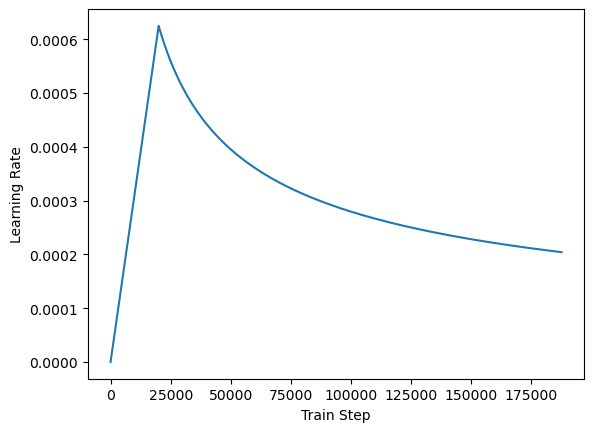

In [ ]:
tmp_lr = CustomSchedule(128, 20_000, weight_decay=None)
plt.plot(tmp_lr(tf.range(12_000_000 // 64, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show();


In [ ]:
####################################################

def flat_gradients(grads_or_idx_slices: tf.Tensor) -> tf.Tensor:
    '''Convert gradients if it's tf.IndexedSlices.
    When computing gradients for operation concerning `tf.gather`, the type of gradients 
    '''
    if type(grads_or_idx_slices) == tf.IndexedSlices:
        return tf.scatter_nd(
            tf.expand_dims(grads_or_idx_slices.indices, 1),
            grads_or_idx_slices.values,
            tf.cast(grads_or_idx_slices.dense_shape, tf.int64)
        )
    return grads_or_idx_slices

def backward_optimization(num_grad_steps, global_gradients, step_gradients, step, model, optimizer):
    for i, g in enumerate(step_gradients):
        step_gradients[i] += flat_gradients(g) / num_grad_steps
    global_gradients = global_gradients + step_gradients
    if (step + 1) % num_grad_steps == 0:
        global_gradients = zip(global_gradients, model.trainable_variables)
        optimizer.apply_gradients(global_gradients)
        global_gradients = []
    return global_gradients


@tf.function
def train_step(*inputs, target, **kwargs):
    l_loss = kwargs['loss']
    with tf.GradientTape() as tape:
        predictions = model(*inputs, training=True)
        loss = loss_function(target, predictions)
        scaled_loss = optimizer.get_scaled_loss(loss)

    scaled_gradients = tape.gradient(scaled_loss, model.trainable_variables)
    gradients = optimizer.get_unscaled_gradients(scaled_gradients)
    # gradients = tape.gradient(loss, model.trainable_variables)
    # optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    l_loss(loss)
    return gradients
  
@tf.function
def test_step(*inputs, target, **kwargs):
    l_loss = kwargs['loss']
    predictions = model(*inputs, training=False)
    loss = loss_function(target, predictions)
    l_loss(loss)


def metrics_reset_states(*metrics):
    for metric in metrics:
        metric.reset_states()


def fancy_printer(loss_tracker, epoch, batch_num, start, step='train', dict_metrics={}, num_epochs=1, **kwargs):
    dict_print_metrics = {' '.join(f"{key}:{value:.4f}" for key, value in dict_metrics.items())}
    if step!='epoch':
        printer = f'[{step} Epoch]{epoch + 1}/{num_epochs} [Time]{time.time() - start:.2f} [Batch]{batch_num} [Speed]{((time.time() - start)/max(1, batch_num))*1000:.2f}ms/step '
        printer += f'[Loss]{loss_tracker.result():.4f} ' + '[Metrics]' + str(dict_print_metrics)
        print(printer)
    else:
        train_loss, val_loss = kwargs['train_loss'], kwargs['val_loss']
        print(f'\nTime taken for epoch {epoch+1}/{num_epochs}: {time.time() - start:.2f} secs')
        printer = f'[Epoch]{epoch + 1}/{num_epochs} - [Train Loss]{train_loss.result():.4f} '
        printer += f'- [Val Loss]{val_loss.result():.4f} ' + str(dict_print_metrics)
        print(printer)


def log_wandb_metrics(step='train', num_step=0, dict_metrics=None, gradients=None, plot_image=False, **kwargs):
    # Scalar metrics
    if step=='train' or step=='val':
        wandb.log({name : value for name, value in dict_metrics.items()}, step=num_step)
    if step=='epoch':
        wandb.log({f'epoch_{name}' : value for name, value in dict_metrics.items()}, step=num_step)

    # Gradients
    if gradients:
        wandb.log({
            'mean_norm_gradients' : np.mean([tf.norm(x) for x in gradients]), 
            'max_norm_gradients': np.max([tf.norm(x) for x in gradients])
        })

####################################################


In [ ]:
####################################################

class BERT4REC_CONFIG:
    num_items = NUM_ITEMS
    path_tfrecords = '../tfrecords/tfrecords_v0.3/'
    restore_last_chekpoint = (False, 'model_bert4rec_complete_v0.4_finetuned')
    model_name = 'model_bert4rec_complete_0.4.1'
    checkpoint_filepath = f'../2_Models/'
    num_records_dataset = 12_000_000
    batch_size = 64
    num_grad_accum_steps = 2
    seq_len = 10
    mask_prob = 0.35
    reverse_prob = 0.25
    emb_dim = 16
    trf_dim = 16
    num_heads = 2
    num_layers = 1
    ff_dim = trf_dim*4
    drop_rate = 0.1
    att_drop_rate = 0.1
    epochs = 5
    early_stopping = 5
    batch_num_printer_train = 100
    batch_num_printer_val = 100
    clipnorm = 1
    num_iters_save_checkpoint = 10_000
    scheduler_scaler = 128 
    warmup_steps = 20_000
    log_wandb = False
    

list_paths_train = [f'{BERT4REC_CONFIG.path_tfrecords}na_split=train/' + x for x in os.listdir(f'{BERT4REC_CONFIG.path_tfrecords}na_split=train')]
np.random.shuffle(list_paths_train)
list_paths_val = [f'{BERT4REC_CONFIG.path_tfrecords}na_split=val/' + x for x in os.listdir(f'{BERT4REC_CONFIG.path_tfrecords}na_split=val')]

train_dataloader = Bert4RecDataLoader(list_paths_train, 
                                     num_items=BERT4REC_CONFIG.num_items, 
                                     seq_len=BERT4REC_CONFIG.seq_len, 
                                     batch_size=BERT4REC_CONFIG.batch_size, 
                                     mask_prob=BERT4REC_CONFIG.mask_prob, 
                                     reverse_prob=BERT4REC_CONFIG.reverse_prob, 
                                     is_test=False,
                                     is_val=False,
                                     shuffle=True,
                                     drop_remainder=True).get_generator()

val_dataloader = Bert4RecDataLoader(list_paths_val, 
                                     num_items=BERT4REC_CONFIG.num_items, 
                                     seq_len=BERT4REC_CONFIG.seq_len,  
                                     batch_size=BERT4REC_CONFIG.batch_size, 
                                     mask_prob=0.0, 
                                     reverse_prob=0.0,  
                                     get_session=False,
                                     is_val=True,
                                     is_test=False,
                                     shuffle=False).get_generator()



tf.keras.backend.clear_session()

model = build_model_bert4Rec(num_items=BERT4REC_CONFIG.num_items, model_cfg=BERT4REC_CONFIG)
# model = tf.keras.models.load_model(f'../2_Models/seq_len{BERT4REC_CONFIG.seq_len}_{BERT4REC_CONFIG.load_model_name}/', compile=False)
optimizer = optimizers.Adam(learning_rate=CustomSchedule(BERT4REC_CONFIG.scheduler_scaler, 
                            warmup_steps=BERT4REC_CONFIG.warmup_steps),
                            clipnorm=BERT4REC_CONFIG.clipnorm)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)                           

# tf.config.optimizer.set_jit(True)
                            
# Build utils
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpoint_path = create_folder_with_version(BERT4REC_CONFIG.model_name, BERT4REC_CONFIG.checkpoint_filepath)
ckpt_manager = tf.train.CheckpointManager(ckpt, os.path.join(BERT4REC_CONFIG.checkpoint_filepath, checkpoint_path, 'checkpoints'), 
                                          max_to_keep=10)
if BERT4REC_CONFIG.restore_last_chekpoint[0]:
    ckpt.restore(BERT4REC_CONFIG.restore_last_chekpoint[1])
    print('Latest checkpoint restored!!')

# Loss function
loss_function = custom_loss_bert4rec()

# Trackers
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

##############################################

total_step, val_step = 0, 0
global_gradients = []
for epoch in range(BERT4REC_CONFIG.epochs):
    start = time.time()
    print('===='*20)
    print(f'Epoch {epoch + 1}')
    metrics_reset_states(train_loss, val_loss)
    
    for batch_num, batch_data in enumerate(train_dataloader):
        inputs, target = batch_data
        step_gradients = train_step(inputs, target=target, loss=train_loss)
        global_gradients = backward_optimization(BERT4REC_CONFIG.num_grad_accum_steps, global_gradients, step_gradients, total_step, model, optimizer)
        if batch_num % BERT4REC_CONFIG.batch_num_printer_train == 0:
            train_dict_metrics = {x.name : x.result() for x in [train_loss]}
            fancy_printer(train_loss, epoch, batch_num, start, step='Train', num_epochs=BERT4REC_CONFIG.epochs, dict_metrics=train_dict_metrics)
            if BERT4REC_CONFIG.log_wandb:
                log_wandb_metrics(step='train', num_step=total_step, gradients=global_gradients, dict_metrics=train_dict_metrics) 
        
        total_step += 1  

        if total_step % BERT4REC_CONFIG.num_iters_save_checkpoint==0:
            print(f'Saving checkpoint for epoch {epoch+1} at step {total_step} on path {checkpoint_path}')        
            ckpt_save_path = ckpt_manager.save()
            
    for val_batch_num, val_batch_data in enumerate(val_dataloader):
        inputs, target = val_batch_data
        test_step(inputs, target=target, loss=val_loss)
        val_step += 1
        if val_batch_num % BERT4REC_CONFIG.batch_num_printer_val == 0:
            val_dict_metrics = {x.name : x.result() for x in [val_loss]}
            fancy_printer(val_loss, epoch, val_batch_num, start, step='Val', num_epochs=BERT4REC_CONFIG.epochs, dict_metrics=val_dict_metrics)    
            if BERT4REC_CONFIG.log_wandb:
                log_wandb_metrics(step='val', num_step=val_step, dict_metrics=val_dict_metrics) 
                # if val_batch_num==0:
                #     log_wandb_metrics(step=None, plot_image=True, 
                #                       model=model, inputs=inputs, epoch=epoch, target=target, stats=stats)

    print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_path}')        
    ckpt_save_path = ckpt_manager.save()
    
    epoch_dict_metrics = {x.name : x.result() for x in [train_loss, val_loss]}
    printer = fancy_printer(None, epoch, epoch, start, step='epoch', dict_metrics=epoch_dict_metrics, 
                            train_loss=train_loss, val_loss=val_loss)
    if BERT4REC_CONFIG.log_wandb:
        log_wandb_metrics(step='epoch', num_step=total_step, dict_metrics=epoch_dict_metrics)

if BERT4REC_CONFIG.log_wandb:
    # wandb.save(checkpoint_path)
    wandb.finish()


####################################################

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
Epoch 1
[Train Epoch]1/5 [Time]2.26 [Batch]0 [Speed]2255.03ms/step [Loss]14.0784 [Metrics]{'train_loss:14.0784'}
[Train Epoch]1/5 [Time]29.08 [Batch]100 [Speed]290.82ms/step [Loss]14.0927 [Metrics]{'train_loss:14.0927'}
[Train Epoch]1/5 [Time]55.82 [Batch]200 [Speed]279.09ms/step [Loss]14.0927 [Metrics]{'train_loss:14.0927'}
[Train Epoch]1/5 [Time]82.34 [Batch]300 [Speed]274.45ms/step [Loss]14.0918 [Metrics]{'train_loss:14.0918'}
[Train Epoch]1/5 [Time]108.85 [Batch]400 [Speed]272.12ms/step [Loss]14.0903 [Metrics]{'train_loss:14.0903'}
[Train Epoch]1/5 [Time]135.34 [Batch]500 [Speed]270.68ms/step [Loss]14.0875 [Metrics]{'train_loss:14.0875'}
[Train Epoch]1/5 [Time]161.93 [Batch]600 [Speed]269.88ms/step [Loss]14.0839 [Metrics]{'train_loss:14.0839'}
[

KeyboardInterrupt: 

# Validation

In [11]:
def get_score_metric(y_true, y_pred, type_target, k=20):
    score = 0
    if len(y_true)==0:
        return None
    if type_target=='clicks':
        num_targets = 1
        hits = len([x for x in y_pred if x==y_true[0]])
    else:
        num_targets = min(k, len(y_true))
        hits = len([x for x in y_pred if x in y_true])
    score = hits / num_targets
    return score

tf.keras.backend.clear_session()
# model = models.load_model('../2_Models/seq_len10_model_bert4rec_complete_v0.4_finetuned/', compile=False)
list_paths_val = ['../tfrecords/tfrecords_v0.3/na_split=val/' + x for x in os.listdir('../tfrecords/tfrecords_v0.3/na_split=val')]
val_dataloader = Bert4RecDataLoader(list_paths_val, 
                                     num_items=NUM_ITEMS, 
                                     seq_len=10, 
                                     seq_len_target=20, 
                                     batch_size=32, 
                                     mask_prob=0.0, 
                                     reverse_prob=0.0, 
                                     is_val=True,
                                     get_session=True, 
                                     is_test=False,
                                     shuffle=False).get_generator()


list_sessions, list_predictions, list_trues, list_types = [], [], [], []
for num_batch, batch in enumerate(tqdm(val_dataloader)):
    features, targets, session = batch
    seq_items, seq_type, seq_time = features
    target, type_target = targets
    idxs = tf.argmin(seq_items[:, :, 0], 1).numpy()
    for type_ in ['clicks', 'carts', 'orders']:
        seq_type_new = [tf.concat([
                        seq_type[i, :ix],
                        tf.constant([[dict_map_type[type_]]], tf.int64),
                        seq_type[i, ix+1:]], axis=0)
                    for i, ix in enumerate(idxs)]
        features = (seq_items, tf.stack(seq_type_new, axis=0), seq_time)
        preds = model(features, training=False)
        preds = tf.gather(preds, indices=idxs, axis=1, batch_dims=1)
        topk_scores, topk_idxs = tf.math.top_k(preds, k=20)
        topk_idxs = np.asarray([[x for x in topk_idxs.numpy()[i, :]] for i in range(topk_idxs.numpy().shape[0])])
        labels = [list(set([_target for _type, _target in zip(type_target.numpy()[i], target.numpy()[i]) if dict_map_type[type_]==_type and _target!=0])) for i in range(target.shape[0])]
        ###
        list_sessions.append(session.numpy())
        list_predictions.append(topk_idxs)
        list_types.append([type_ for _ in range(seq_items.shape[0])])
        list_trues = list_trues + labels
    if num_batch==1_000:
        break

df_val = pd.DataFrame({
    'session' : np.concatenate(list_sessions),
    'predictions' : np.concatenate(list_predictions).tolist(),
    'trues' : list_trues,
    'type' : np.concatenate(list_types)
})

df_val['score'] = df_val.progress_apply(lambda x: get_score_metric(x['trues'], x['predictions'], x['type']), axis=1)

display(df_val.describe())
dict_scores = df_val.groupby('type')['score'].mean().to_dict()
display(dict_scores)
kaggle_metric = 0.1*dict_scores['clicks'] + 0.3*dict_scores['carts'] + 0.6*dict_scores['orders']
print(f'Kaggle Metric: {kaggle_metric:.4f}')

# v0.4 seqlen=10
# {'carts': 0.222143,
#  'clicks': 0.163726,
#  'orders': 0.301489}
# Kaggle Metric: 0.2639089

# v0.4_finetuned seqlen=10
# {'carts': 0.23272587826464677,
#  'clicks': 0.16818629058707774,
#  'orders': 0.31957377011651095}
# Kaggle Metric: 0.2783808

1000it [01:59,  8.34it/s]
100%|██████████| 96096/96096 [00:01<00:00, 71928.35it/s]


,session,score
count,9.609600e+04,40454.000000
mean,6.358616e+06,0.189249
std,3.721860e+06,0.383285
min,2.200000e+02,0.000000
25%,3.118926e+06,0.000000
50%,6.336554e+06,0.000000
75%,9.541742e+06,0.000000
max,1.289966e+07,1.000000


{'carts': 0.23110458407992615,
 'clicks': 0.1673007543456871,
 'orders': 0.3166333854597084}

Kaggle Metric: 0.2760


# Inference

In [ ]:
tf.debugging.set_log_device_placement(True)
tf.keras.backend.clear_session()
model = models.load_model('../2_Models/seq_len10_model_bert4rec_complete_v0.4/', compile=False)


list_paths_test = ['../tfrecords/tfrecords_v0.3/na_split=test/' + x for x in os.listdir('../tfrecords/tfrecords_v0.3/na_split=test')]
test_dataloader = Bert4RecDataLoader(list_paths_test, 
                                     num_items=NUM_ITEMS, 
                                     seq_len=10,  
                                     batch_size=64, 
                                     mask_prob=0.0, 
                                     reverse_prob=0.0,  
                                     is_val=False,
                                     is_test=True,
                                     get_session=True,
                                     shuffle=False).get_generator()

list_predictions, list_sessions, list_types, list_scores = [], [], [], []
for num_batch, batch in enumerate(tqdm(test_dataloader)):
    features, target, session = batch
    seq_items, seq_type, seq_time = features
    idxs = tf.argmin(seq_items[:, :, 0], 1).numpy()
    ###
    for type_ in ['clicks', 'carts', 'orders']:
        seq_type_new = [tf.concat([
                        seq_type[i, :ix],
                        tf.constant([[dict_map_type[type_]]], tf.int64),
                        seq_type[i, ix+1:]], axis=0)
                    for i, ix in enumerate(idxs)]
        features = (seq_items, tf.stack(seq_type_new, axis=0), seq_time)
        preds = model(features, training=False)
        preds = tf.gather(preds, indices=idxs, axis=1, batch_dims=1)
        topk_scores, topk_idxs = tf.math.top_k(preds, k=20)
        topk_idxs = np.asarray([[dict_map[x] for x in topk_idxs.numpy()[i, :]] for i in range(topk_idxs.numpy().shape[0])])
        topk_idxs = topk_idxs - 1
        list_predictions.append(topk_idxs)
        list_types.append([type_ for _ in range(seq_items.shape[0])])
        list_sessions.append(session.numpy())
    # if num_batch==100:
    #     break
    

# 52244it [2:47:45,  5.19it/s]


In [ ]:
name_submission = f"submission_{datetime.now().__str__().split('.')[0].replace(' ', '_').replace('-', '_').replace(':', '_')}"

df_inference = pd.DataFrame({
    'session' : np.concatenate(list_sessions),
    'predictions' : np.concatenate(list_predictions).tolist(),
    'type' : np.concatenate(list_types)
})

df_inference['session_type'] = df_inference['session'].astype(str) + '_' + df_inference['type']
df_inference['labels'] = df_inference['predictions'].apply(lambda x : ' '.join([str(y) for y in x]))
df_inference[['session_type', 'labels']].to_csv(f'../3_Submissions/{name_submission}.csv', index=False)

print(df_inference.shape)
display(
    df_inference
)